In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import json
from matplotlib import pyplot as plt
import numpy as np
from baselines import ZeroBaselineFactory
from models import load_distilbert

from numpy.random import randn
from evaluators import ProportionalityEvaluator
import nevergrad as ng


In [2]:
def square(x):
    return sum((x - 0.5) ** 2)

# optimization on x as an array of shape (2,)
optimizer = ng.optimizers.NGOpt(parametrization=2, budget=100)
recommendation = optimizer.minimize(square)  # best value
print(recommendation.value)

[0.5 0.5]


In [3]:
print(sorted(ng.optimizers.registry.keys()))


['ASCMADEthird', 'AdaptiveDiscreteOnePlusOne', 'AlmostRotationInvariantDE', 'AnisotropicAdaptiveDiscreteOnePlusOne', 'AvgMetaRecenteringNoHull', 'BO', 'BOSplit', 'BayesOptimBO', 'CM', 'CMA', 'CMandAS2', 'CMandAS3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'ChainCMAPowell', 'ChainDiagonalCMAPowell', 'ChainMetaModelPowell', 'ChainMetaModelSQP', 'ChainNaiveTBPSACMAPowell', 'ChainNaiveTBPSAPowell', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteBSOOnePlusOne', 'DiscreteDoerrOnePlusOne', 'DiscreteLenglerOnePlusOne', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'FCMA', 'GeneticDE', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'HullAvgMetaRecentering', 'HullAvgMetaTuneRecentering', 'LHSSearch', 'LargeHaltonSearch', 'LhsDE', 'MetaModel', 'MetaModelOnePlusOne', 'MetaRecentering', 'MetaTuneRecentering', 'MixES', 'MultiCMA', 'MultiDiscrete', 'MultiScaleCMA', 'MutDE', 'NGO', 'NGOpt', 'NGOpt10', 'NG

In [4]:
model = load_distilbert(from_notebook=1)
with open("./../data/imdb-distilbert-first-1000.json", "r") as fp:
    dataset = json.load(fp)


In [5]:
observation = np.asarray(dataset[0]["input_ids"][:512])
evaluator = ProportionalityEvaluator(model=model, baseline_factory=ZeroBaselineFactory)
objective = lambda candidate: evaluator.compute_tpn(observation=observation, attribution_values=candidate)

res = objective(np.random.random(observation.shape))  # objective should be called on attributions
print(res)

0.10137378313365433


In [26]:
evaluator = ProportionalityEvaluator(model=model, baseline_factory=ZeroBaselineFactory)
results = []
for observation in (dataset[0], dataset[2]):
    observation = np.asarray(observation["input_ids"][:512])


    def objective(candidate):
        res = evaluator.compute_tpn(observation=observation, attribution_values=candidate)
        if res is None:
            return 10 # float("inf")
        return res


    param = ng.p.Array(shape=observation.shape)
    param.set_bounds(lower=0)
    param.set_mutation(sigma=1)

    optimizer = ng.optimizers.NGOpt(parametrization=param, budget=300)
    recommendation = optimizer.minimize(objective)  # best value
    print(objective(recommendation.value))
    results.append(recommendation)
    # print(recommendation.value)
    #plt.scatter(y=recommendation.value, x=list(range(len(recommendation.value))))
    # plt.hist(recommendation.value, bins=50)



KeyboardInterrupt: 

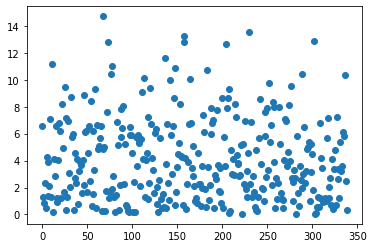

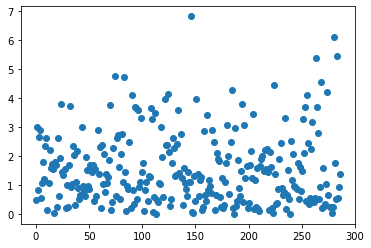

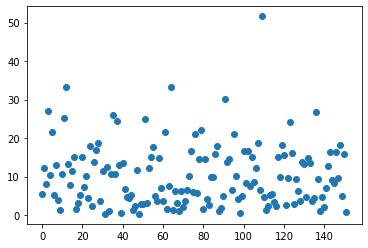

In [25]:
for i, recommendation in enumerate(results):
    fig, ax = plt.subplots()
    ax.scatter(y=recommendation.value, x=list(range(len(recommendation.value))))
    fig.savefig(f"./scatter{i}-2.png")

In [22]:
plt.savefig()

TypeError: savefig() missing 1 required positional argument: 'fname'

<Figure size 432x288 with 0 Axes>